In [1]:
library(Seurat)
library(dplyr)
library(tximport)
library(ggplot2)
library(ggsci)
# library(harmony)
library(RColorBrewer)
# library(DoubletFinder)
# library(Rmagic)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
files <- file.path('/data/Matthew/scrna/sc_align/cro1_v7_nodecoy_exp10k/alevin/quants_mat.gz')
txi <- tximport(files, type = "alevin")
cro_1 <- CreateSeuratObject(counts = txi$counts, project = "Alevin")

files <- file.path('/data/Matthew/scrna/sc_align/cro2_v7_nodecoy_exp18k/alevin/quants_mat.gz')
txi <- tximport(files, type = "alevin")
cro_2 <- CreateSeuratObject(counts = txi$counts, project = "Alevin")

files <- file.path('/data/Matthew/scrna/sc_align/cro3_v7_nodecoy_exp13k/alevin/quants_mat.gz')
txi <- tximport(files, type = "alevin")
cro_3 <- CreateSeuratObject(counts = txi$counts, project = "Alevin")

alv_obj <- merge(x = cro_1,
                 y = c(cro_2, cro_3),
                 add.cell.ids = c("cro_alv1", "cro_alv2", "cro_alv3"),
                 project = "Alevin")

reading in alevin gene-level counts across cells with fishpond

reading in alevin gene-level counts across cells with fishpond

reading in alevin gene-level counts across cells with fishpond



In [3]:
cr1_matrix <- Read10X(data.dir = '/data/Matthew/scrna/sc_align/cro1_extend_v7/outs/filtered_feature_bc_matrix')
cr1_obj <- CreateSeuratObject(counts = cr1_matrix, project = 'Cell Ranger')

cr2_matrix <- Read10X(data.dir = '/data/Matthew/scrna/sc_align/cro2_extend_v7/outs/filtered_feature_bc_matrix')
cr2_obj <- CreateSeuratObject(counts = cr2_matrix, project = 'Cell Ranger')

cr3_matrix <- Read10X(data.dir = '/data/Matthew/scrna/sc_align/cro3_extend_v7/outs/filtered_feature_bc_matrix')
cr3_obj <- CreateSeuratObject(counts = cr3_matrix, project = 'Cell Ranger')

cr_obj <- merge(x = cr1_obj,
                y = c(cr2_obj, cr3_obj),
                add.cell.ids = c("cro_cr1", "cro_cr2", "cro_cr3"),
                project = "Cell Ranger")

In [4]:
obj.combine <- merge(cr_obj, alv_obj)

id_path <- '/data/Matthew/scrna/02.Clustering/id_latest/'
mt_less <- readLines(paste(id_path, 'mt-id-less.txt',sep = '/'))
chl <- readLines(paste(id_path, 'newcp.gene.id',sep = '/'))
s.genes <- readLines(paste(id_path, 'cellcycle.s.id',sep = '/'))
g2m.genes <- readLines(paste(id_path, 'cellcycle.g2m.id',sep = '/'))

# calculating feature percentage
obj.combine[["percent.mt"]] <- PercentageFeatureSet(obj.combine, features = intersect(mt_less, rownames(obj.combine)), )
obj.combine[["percent.chl"]] <- PercentageFeatureSet(obj.combine, features = intersect(chl, rownames(obj.combine)))

# filtering cells
upper_feature <- 6000
lower_feature <- 500
upper_count <- 30000
lower_count <- 500

obj.combine <- subset(
  obj.combine,
  subset =
    nFeature_RNA > lower_feature &
    nFeature_RNA < upper_feature &
    nCount_RNA < upper_count &
    nCount_RNA > lower_count &
    percent.mt < 3 &
    percent.chl < 40
)

# standard pipeline
obj.combine <- obj.combine %>%
  NormalizeData() %>%
  FindVariableFeatures() %>%
  ScaleData() %>%
  RunPCA(verbose = F)

Centering and scaling data matrix



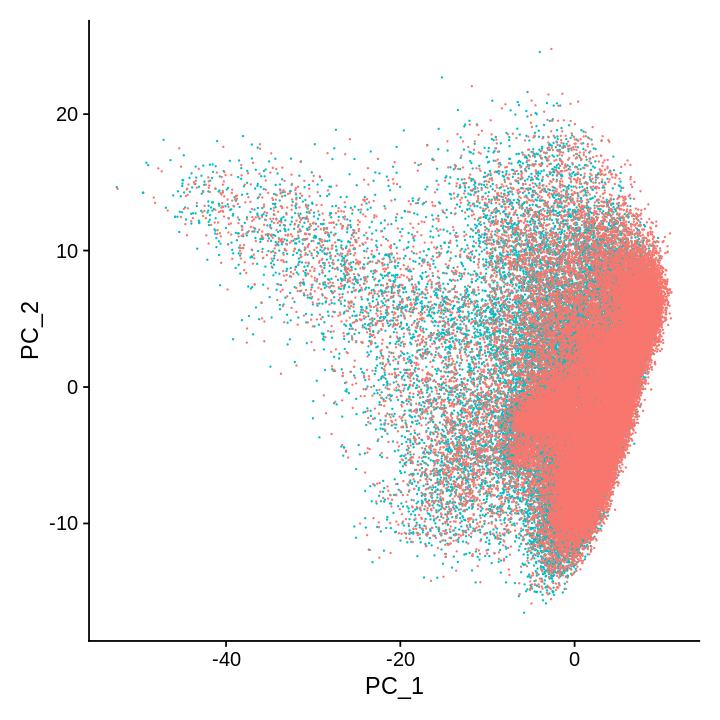

In [6]:
options(repr.plot.height = 6, repr.plot.width = 6)
PCAPlot(obj.combine) + guides(colour = "none")#+ theme(legend.position = c(0.7, 0.9))
ggsave('pca_plot.png', height = 5, width = 5, dpi = 300)

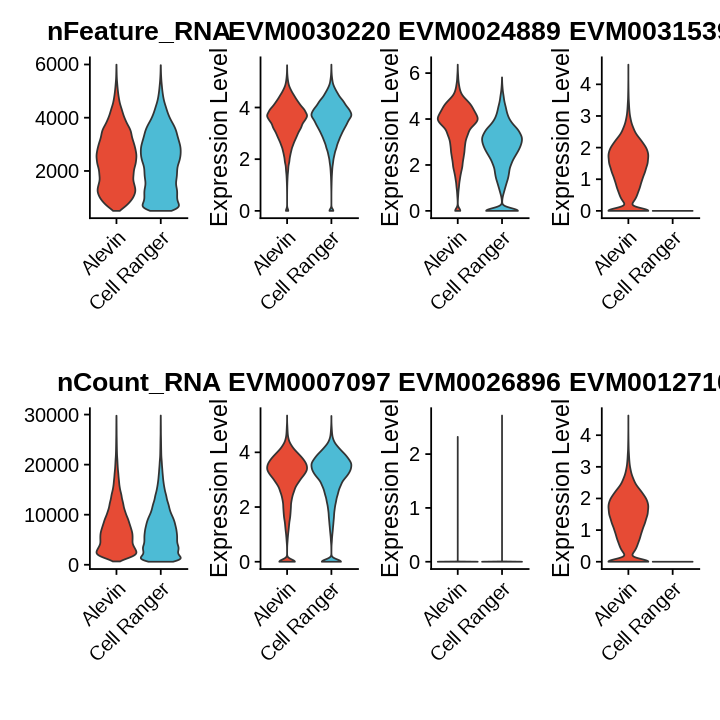

In [7]:
p1 <- VlnPlot(obj.combine, features = c("nFeature_RNA", "nCount_RNA"), pt.size = 0, ncol = 1) & scale_fill_npg() & labs(x='')
p2 <- VlnPlot(obj.combine, features = c('EVM0030220', 'EVM0007097'), pt.size = 0, ncol = 1) & scale_fill_npg() & labs(x='')
p3 <- VlnPlot(obj.combine, features = c('EVM0024889', 'EVM0026896'), pt.size = 0, ncol = 1)  & scale_fill_npg() & labs(x='')
p4 <- VlnPlot(obj.combine, features = c('EVM0031539', 'EVM0012710'), pt.size = 0, ncol = 1)  & scale_fill_npg() & labs(x='')

p1 | p2 | p3 | p4

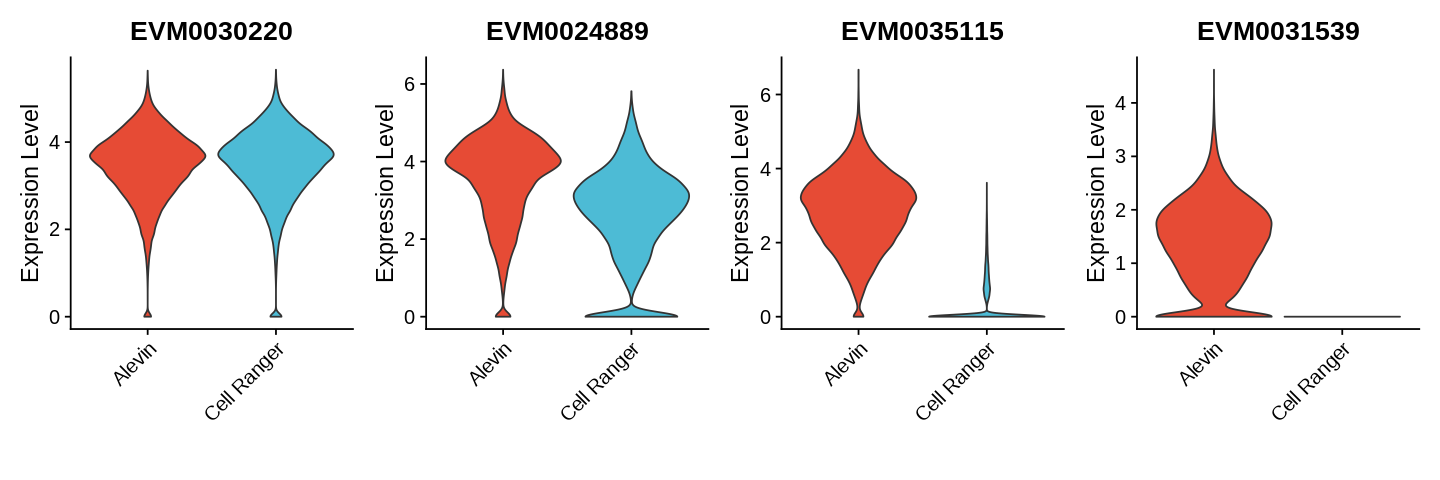

In [8]:
options(repr.plot.height = 4, repr.plot.width = 12)
VlnPlot(obj.combine,
#         features = c("EVM0030220", "EVM0024889", "EVM0001360", "EVM0035115", "EVM0010963", "EVM0031539"),
        features = c("EVM0030220", "EVM0024889", "EVM0035115", "EVM0031539"),
        pt.size = 0, ncol = 4
       ) & scale_fill_npg() & labs(x="")
ggsave('gene-level.compare.vlnplot.pdf', height = 4, width = 12)

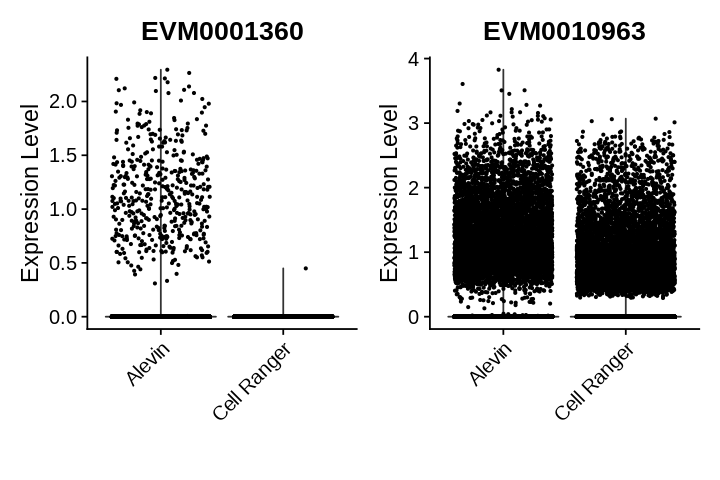

In [14]:
options(repr.plot.height = 4, repr.plot.width = 6)
VlnPlot(obj.combine,
#         features = c("EVM0030220", "EVM0024889", "EVM0001360", "EVM0035115", "EVM0010963", "EVM0031539"),
        features = c("EVM0001360", "EVM0010963"),
        pt.size = 0.5, ncol = 2
       ) & scale_fill_npg() & labs(x="")

# GO expression

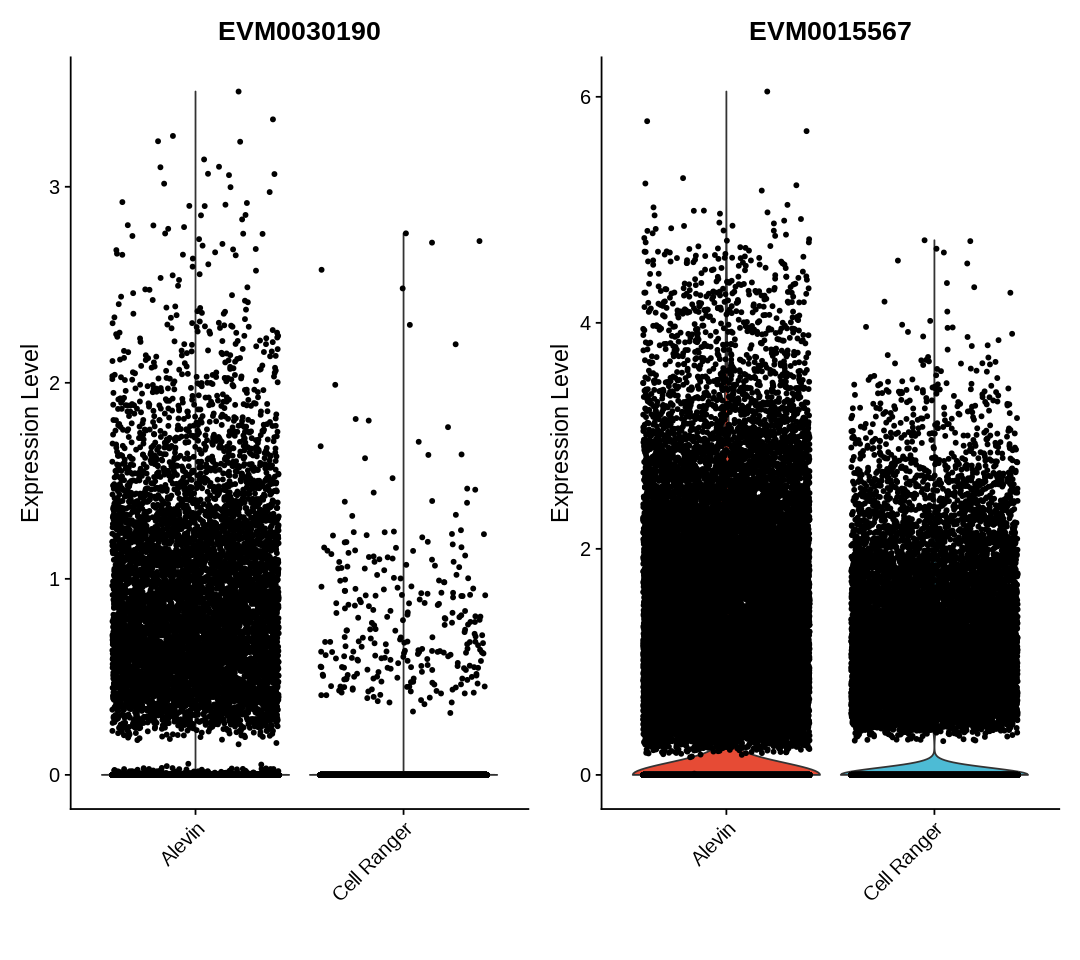

In [61]:
options(repr.plot.height = 8, repr.plot.width = 9)
VlnPlot(obj.combine, features = c("EVM0030190", "EVM0015567"),
        pt.size = 1, ncol = 2
    ) & scale_fill_npg() & labs(x="")

In [62]:
ggsave('compare.pdf', width = 12, height = 4)

In [22]:
avg_exp <- AverageExpression(obj.combine)

In [24]:
avg_exp$RNA %>% head()

,Alevin,Cell Ranger
EVM0006883,0.00000000,0
EVM0032325,0.03399165,0
EVM0007132,0.00000000,0
EVM0022991,0.00000000,0
EVM0024967,0.00000000,0
EVM0022921,0.00000000,0


In [25]:
write.csv(avg_exp, file='avg_exp.csv')

# cell screen

In [9]:
alv_obj[["percent.mt"]] <- PercentageFeatureSet(alv_obj, features = intersect(mt_less, rownames(alv_obj)), )
alv_obj[["percent.chl"]] <- PercentageFeatureSet(alv_obj, features = intersect(chl, rownames(alv_obj)))

# Create data frame and attach color category column
cell.meta <- alv_obj[[c('nFeature_RNA', 'nCount_RNA', 'percent.mt', 'percent.chl')]]
cell.meta$cell.screen <- ifelse(cell.meta$percent.mt < 3 & cell.meta$nCount_RNA < 30000 & cell.meta$nCount_RNA > 500, 'normal', 'bad')

# plot omitted cells due to percent.mt and chloroplast at the same plot
cell.meta$cell.screen <-
  ifelse(
    cell.meta$percent.chl < 40 &
      cell.meta$percent.mt < 3 ,
    ifelse(
      cell.meta$nFeature_RNA > 500 &
        cell.meta$nFeature_RNA < 6000 &
        cell.meta$nCount_RNA > 500 &
        cell.meta$nCount_RNA < 30000,
      'High quality cells',
      'Filtered cells'
    ),
    ifelse(
      cell.meta$percent.mt >= 3 &
        cell.meta$percent.chl < 40,
      'Percent.mt >= 3',
      ifelse(
        cell.meta$percent.chl >= 40 &
          cell.meta$percent.mt < 3,
        'Percent.chl >= 40',
        'Percent.chl >= 40 &\n Percent.mt >= 3'
      )
    )
  )
p5 <- ggplot(cell.meta, aes(x = log(nCount_RNA), y = log(nFeature_RNA), colour = cell.screen)) +
  geom_point(size = 0.8) +
  geom_vline(xintercept = c(log(500), log(30000)), lty = 4, col = "black", lwd = 0.8) +
  geom_hline(yintercept = c(log(500), log(6000)), lty = 4, col = "black", lwd = 0.8) +
  xlim(c(5.5, 10.5)) +
  ylim(c(5.5, 9)) +
  scale_colour_jama() +
  theme_light() +
  guides(colour="none") +
  labs(x = "",
       y = "")

In [10]:
cr_obj[["percent.mt"]] <- PercentageFeatureSet(cr_obj, features = intersect(mt_less, rownames(cr_obj)), )
cr_obj[["percent.chl"]] <- PercentageFeatureSet(cr_obj, features = intersect(chl, rownames(cr_obj)))

# Create data frame and attach color category column
cell.meta <- cr_obj[[c('nFeature_RNA', 'nCount_RNA', 'percent.mt', 'percent.chl')]]
cell.meta$cell.screen <- ifelse(cell.meta$percent.mt < 3 & cell.meta$nCount_RNA < 30000 & cell.meta$nCount_RNA > 500, 'normal', 'bad')

# plot omitted cells due to percent.mt and chloroplast at the same plot
cell.meta$cell.screen <-
  ifelse(
    cell.meta$percent.chl < 40 &
      cell.meta$percent.mt < 3 ,
    ifelse(
      cell.meta$nFeature_RNA > 500 &
        cell.meta$nFeature_RNA < 6000 &
        cell.meta$nCount_RNA > 500 &
        cell.meta$nCount_RNA < 30000,
      'High quality cells',
      'Filtered cells'
    ),
    ifelse(
      cell.meta$percent.mt >= 3 &
        cell.meta$percent.chl < 40,
      'Percent.mt >= 3',
      ifelse(
        cell.meta$percent.chl >= 40 &
          cell.meta$percent.mt < 3,
        'Percent.chl >= 40',
        'Percent.chl >= 40 &\n Percent.mt >= 3'
      )
    )
  )
p6 <- ggplot(cell.meta, aes(x = log(nCount_RNA), y = log(nFeature_RNA), colour = cell.screen)) +
  geom_point(size = 0.8) +
  geom_vline(xintercept = c(log(500), log(30000)), lty = 4, col = "black", lwd = 0.8) +
  geom_hline(yintercept = c(log(500), log(6000)), lty = 4, col = "black", lwd = 0.8) +
  xlim(c(5.5, 10.5)) +
  ylim(c(5.5, 9)) +
  scale_colour_jama() +
  theme_light() +
  guides(colour="none") +
  labs(x = "",
       y = "")

Warning message:
“Removed 816 rows containing missing values (geom_point).”
Warning message:
“Removed 7 rows containing missing values (geom_point).”
Warning message:
“Removed 816 rows containing missing values (geom_point).”
Warning message:
“Removed 7 rows containing missing values (geom_point).”


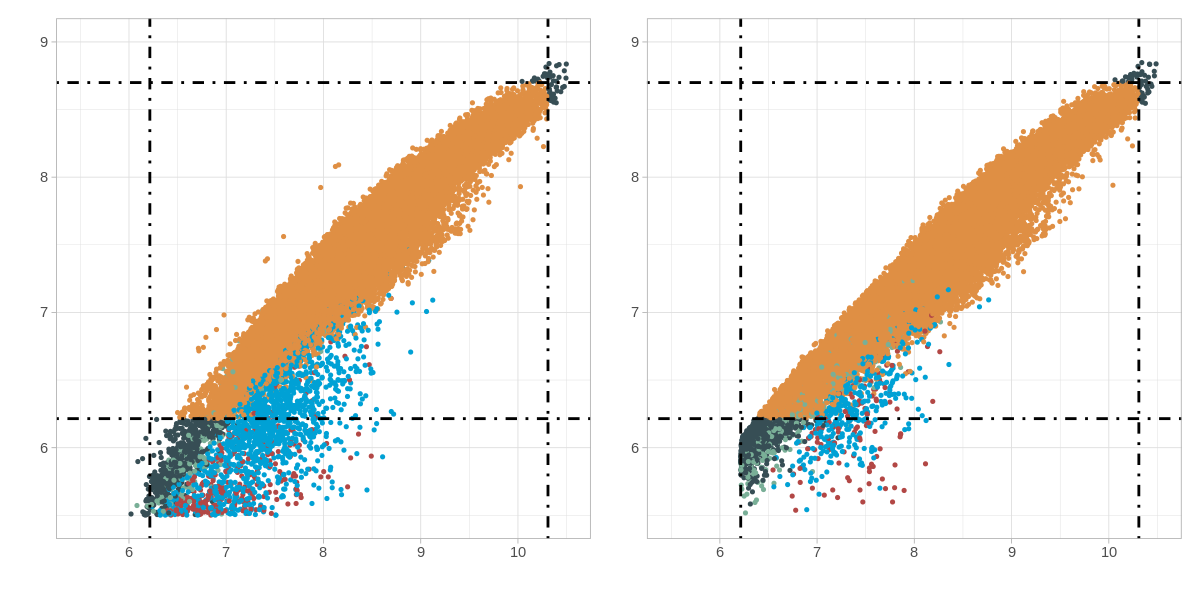

In [11]:
options(repr.plot.height = 5, repr.plot.width = 10)
p5 + p6
ggsave(p5, filename = 'alv_scatter.png', dpi = 300, width = 4, height = 4)
ggsave(p6, filename = 'cr_scatter.png', dpi = 300, width = 4, height = 4)

In [3]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/Matthew/miniconda3/envs/psdtime/lib/libopenblasp-r0.3.17.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] patchwork_1.1.1    ggsci_2.9          ggplot2_3.3.5      dplyr_1.0.7       
[5] tximport_1.18.0    SeuratObject_4.0.2 Seurat_4.0.3      

loaded via a namespace (and not attached):
  [1] Rtsne_0.15                  colorspace_2.0-2           
  [3] deldir_0.2-10               ellipsis_0.3.2    